# Generative modelling versus discriminative modelling

The terminology is not always used consistently (see wikipedia article on <a href="https://en.wikipedia.org/wiki/Generative_model">Generative Model</a>). For a much deeper look into generative modelling see the book <a href="https://www.oreilly.com/library/view/generative-deep-learning/9781492041931/">"Generative Deep Learning"</a> by D. Foster. 

* A **generative** model is a model of the conditional probability of the observable $X$, given a value $y$ for the target variable $Y$:
$$
P(X\vert Y=y)
$$
Sometimes a generative model is defined more generally as a statistical model of the joint probability distribution of $X$ and $Y$:
$$
P(X,Y)
$$
* A **discriminative** model is a model of the conditional probability of the target Y, given an observation x:
$$
P(Y\vert X=x)
$$

The "observation" $X$ can be anything:

* An LHC collision event.
* Images of galaxies.
* Pictures of objects, <a href="https://thispersondoesnotexist.com/">faces</a>, <a href="https://thiscatdoesnotexist.com/">animals</a>, etc.
* Images of <a href="https://thisartworkdoesnotexist.com/">artwork</a>.
* Sounds and <a href="https://topten.ai/music-generators-review/">music</a>.
* Text, for example, papers in <a href="https://thatsmathematics.com/mathgen/">math</a> and <a href="http://snarxiv.org/">theoretical physics</a>, <a href="https://artsexperiments.withgoogle.com/poemportraits">poetry</a>, Shakespeare, valentines, etc.

For concreteness let's discuss image generation. The key idea of image generation is to develop a low-dimensional **latent space** of representations (which is a vector space) where any point can be mapped to a realistic-looking image. The module which encodes this mapping, taking as input a latent point and outputting an image (grid of pixels) is called

* a **decoder** in the case of VAEs
* a **generator** in the case of GANs

## Generating images with variational autoencoders

A **classical image autoencoder** takes an image, maps it to a latent vector space via an "encoder" module, then decodes it back to an output with the same dimensions as the original image, via a "decoder" module. It is then trained by using as target data the same images as the input images, meaning that the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the "code", i.e. the output of the encoder, one can get the autoencoder to learn more or less interesting latent representations of the data. Most commonly, one would constraint the code to be very low-dimensional and sparse (i.e. mostly zeros), in which case the encoder acts as a way to compress the input data into fewer bits of information.

<img src="https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg" width=700>

In practice, such classical autoencoders don't lead to particularly useful or well-structured latent spaces. They're not particularly good at compression, either. For these reasons, they have largely fallen out of fashion over the past years. **Variational autoencoders**, however, augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They have turned out to be a very powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed "code" in the latent space, turns the image into the parameters of a statistical distribution: a mean and a variance. Essentially, this means that we are assuming that the input image has been generated by a statistical process, and that the randomness of this process should be taken into accounting during encoding and decoding. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere, i.e. every point sampled in the latent will be decoded to a valid output.

<img src="https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png" width=700>

In technical terms, here is how a variational autoencoder works. 

* First, an encoder module turns the input samples input_img into two parameters in a latent space of representations, which we will note z_mean and z_log_variance. 
* Then, we randomly sample a point z from the latent normal distribution that is assumed to generate the input image, via z = z_mean + exp(z_log_variance) * epsilon, where epsilon is a random tensor of small values. 
* Finally, a decoder module will map this point in the latent space back to the original input image. Because epsilon is random, the process ensures that every point that is close to the latent location where we encoded input_img (z-mean) can be decoded to something similar to input_img, thus forcing the latent space to be continuously meaningful. Any two close points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: 

* a **reconstruction loss** that forces the decoded samples to match the initial inputs
* a **regularization loss**, which helps in learning well-formed latent spaces and reducing overfitting to the training data.

Let's quickly go over a Keras implementation of a VAE. Schematically, it looks like this:

In [1]:
## Encode the input into a mean and variance parameter
#z_mean, z_log_variance = encoder(input_img)

## Draw a latent point using a small random epsilon
#z = z_mean + exp(z_log_variance) * epsilon

## Then decode z back to an image
#reconstructed_img = decoder(z)

## Instantiate a model
#model = Model(input_img, reconstructed_img)

## Then train the model using 2 losses:
## a reconstruction loss and a regularization loss

The actual code follows. The examples are from <a href="https://blog.keras.io/building-autoencoders-in-keras.html">Building Autoencoders in Keras</a>.

#Example 1: the simplest possible autoencoder

Start with a single fully-connected neural layer as encoder and as decoder:

In [2]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a separate encoder model:

In [3]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

As well as the decoder model:

In [4]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [5]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [6]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 2s 10ms/step - loss: 0.2772 - val_loss: 0.1928
Epoch 2/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1741 - val_loss: 0.1564
Epoch 3/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1454 - val_loss: 0.1338
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1283 - val_loss: 0.1211
Epoch 5/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1178 - val_loss: 0.1125
Epoch 6/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1107 - val_loss: 0.1067
Epoch 7/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1057 - val_loss: 0.1025
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1020 - val_loss: 0.0992
Epoch 9/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0993 - val_loss: 0.0970
Epoch 10/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0975 - val_lo

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [9]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

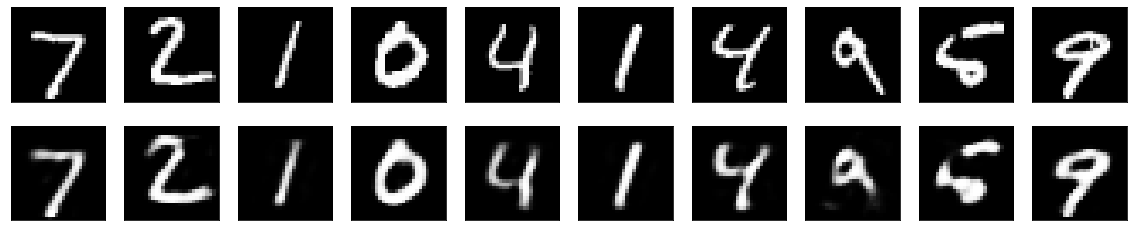

In [10]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. 

# Example 2: variational autoenoder

In [11]:
import keras
from keras import layers

In [12]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [14]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

We can use these parameters to sample new similar points from the latent space:

In [15]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Finally, we can map these sampled latent points back to reconstructed inputs:

In [16]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')


In [17]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_6 (Dense)              (None, 784)               50960     
Total params: 51,152
Trainable params: 51,152
Non-trainable params: 0
_________________________________________________________________


In [18]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           50240       input_3[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            130         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            130         dense_2[0][0]                    
____________________________________________________________________________________________

What we've done so far allows us to instantiate 3 models:

* an end-to-end autoencoder mapping inputs to reconstructions
* an encoder mapping inputs to the latent space
* a generator that can take points on the latent space and will output the corresponding reconstructed samples.

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [19]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

We train our VAE on MNIST digits:

In [20]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=20,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 184.7198 - val_loss: 166.8523
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 164.3882 - val_loss: 163.0841
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 161.5368 - val_loss: 160.9643
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 159.4320 - val_loss: 159.0903
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 157.6597 - val_loss: 157.5636
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 156.2252 - val_loss: 155.9020
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 155.1729 - val_loss: 155.3452
Epoch 8/20
1875/1875 [==============================] - 6s 3ms/step - loss: 154.3188 - val_loss: 154.5668
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 153.7080 - val_loss: 153.6691
Epoch 10/20
1875/1875 [=======================

Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:

In [21]:
# Use Matplotlib
import matplotlib.pyplot as plt

In [22]:
x_test.shape

(10000, 784)

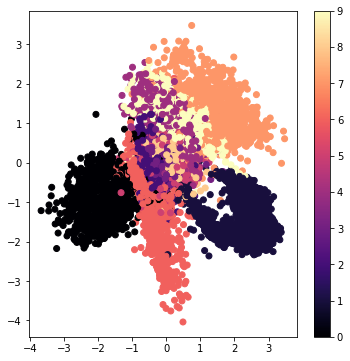

In [23]:
x_test_encoded = np.array(encoder.predict(x_test))

plt.figure(figsize=(6, 6))

plt.scatter(x_test_encoded[0,:, 0], x_test_encoded[0,:, 1], c=y_test, cmap="magma")

plt.colorbar()
plt.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

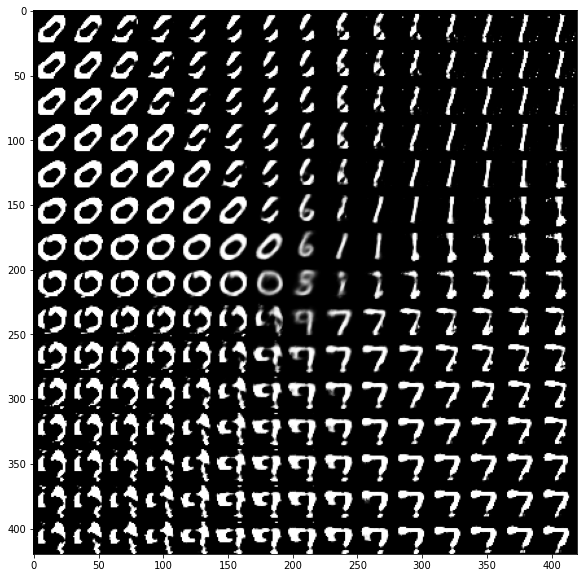

In [24]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()